# FUNGUS MYCETOMA CLASSIFICATION

## Method : decision tree

<p> Reminders about data :
    <ul>
        <li> FM : fungus / BM : bacterial
        <li> label = type + n°patient + _ + n°grain
    </ul>
</p>

In [6]:
%run dataManagementPart2.ipynb

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.decomposition import PCA
from scikitplot.metrics import plot_confusion_matrix, plot_roc_curve

##### 1) Getting data

In [10]:
file1 = './Data/radiomics_features_set1.csv'
file2 = './Data/radiomics_features_set2.csv'

In [11]:
data = readCSV(file1,file2)

In [12]:
# fungus mycetoma type
y = getLabels(data)[1]

# associated data
X = getData(data)[1]

(206, 102) (37, 102) (16, 102)


##### 2) Balancing data

In [13]:
nb1 = y.count(1)
nb2 = y.count(2)
print("Number of type 1 :",nb1)
print("Number of type 2 :",nb2)

balanced_y = []
balanced_X = []

cpt = 0
for i in range(len(y)):
    if y[i] == 1 and cpt != nb2:
        balanced_y.append(y[i])
        balanced_X.append(data.iloc[i])
        cpt += 1
    elif y[i] == 2:
        balanced_y.append(y[i])
        balanced_X.append(X.iloc[i,:])

y = balanced_y 
X = pd.DataFrame(balanced_X,index=[i for i in range(nb2*2)],columns=X.columns)

nb1_end = y.count(1)
nb2_end = y.count(2)
print("Number of type 1 :",nb1_end)
print("Number of type 2 :",nb2_end)

Number of type 1 : 166
Number of type 2 : 111
Number of type 1 : 111
Number of type 2 : 111


##### 3) Preprocessing the data (to remove the negative numbers)

In [14]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

##### 4) Studying the number of features to keep for the PCA

In [15]:
pca = PCA(n_components=102) #creating a PCA for a test (we have 102 features)
pca.fit(X)

variance = pca.explained_variance_ratio_ #calculate variance ratios 
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([37.9, 60.2, 74.3, 81. , 85.6, 88.3, 90.4, 91.8, 93.1, 94. , 94.8,
       95.5, 96.1, 96.6, 97. , 97.4, 97.7, 98. , 98.3, 98.5, 98.7, 98.9,
       99. , 99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6])

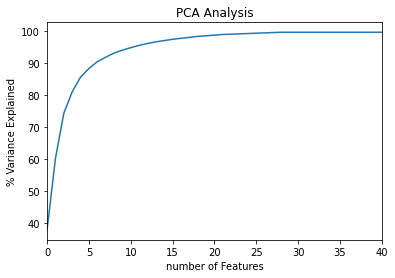

In [16]:
plt.ylabel('% Variance Explained')
plt.xlabel('number of Features')
plt.title('PCA Analysis')
plt.xlim(0,40)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

<p> According to the curve, we need to keep between 10 and 20 features for the PCA. </p>

##### 5) Defining training and testing data

In [17]:
pca_tree = PCA(n_components=10) #creating the PCA for the following decision tree 
pca_tree.fit(X)

#with PCA
Xpca = pca_tree.transform(X)
X_trainPCA, X_testPCA, y_trainPCA, y_testPCA = train_test_split(Xpca,y)
print("Training data dimension :",X_trainPCA.shape)
print("Test data dimension :",X_testPCA.shape)

#without PCA
X_train, X_test, y_train, y_test = train_test_split(X,y)
print("Training data dimension :",X_train.shape)
print("Test data dimension :",X_test.shape)

Training data dimension : (166, 10)
Test data dimension : (56, 10)
Training data dimension : (166, 102)
Test data dimension : (56, 102)


##### 6) Learning 


- Decision Tree Classifier with PCA

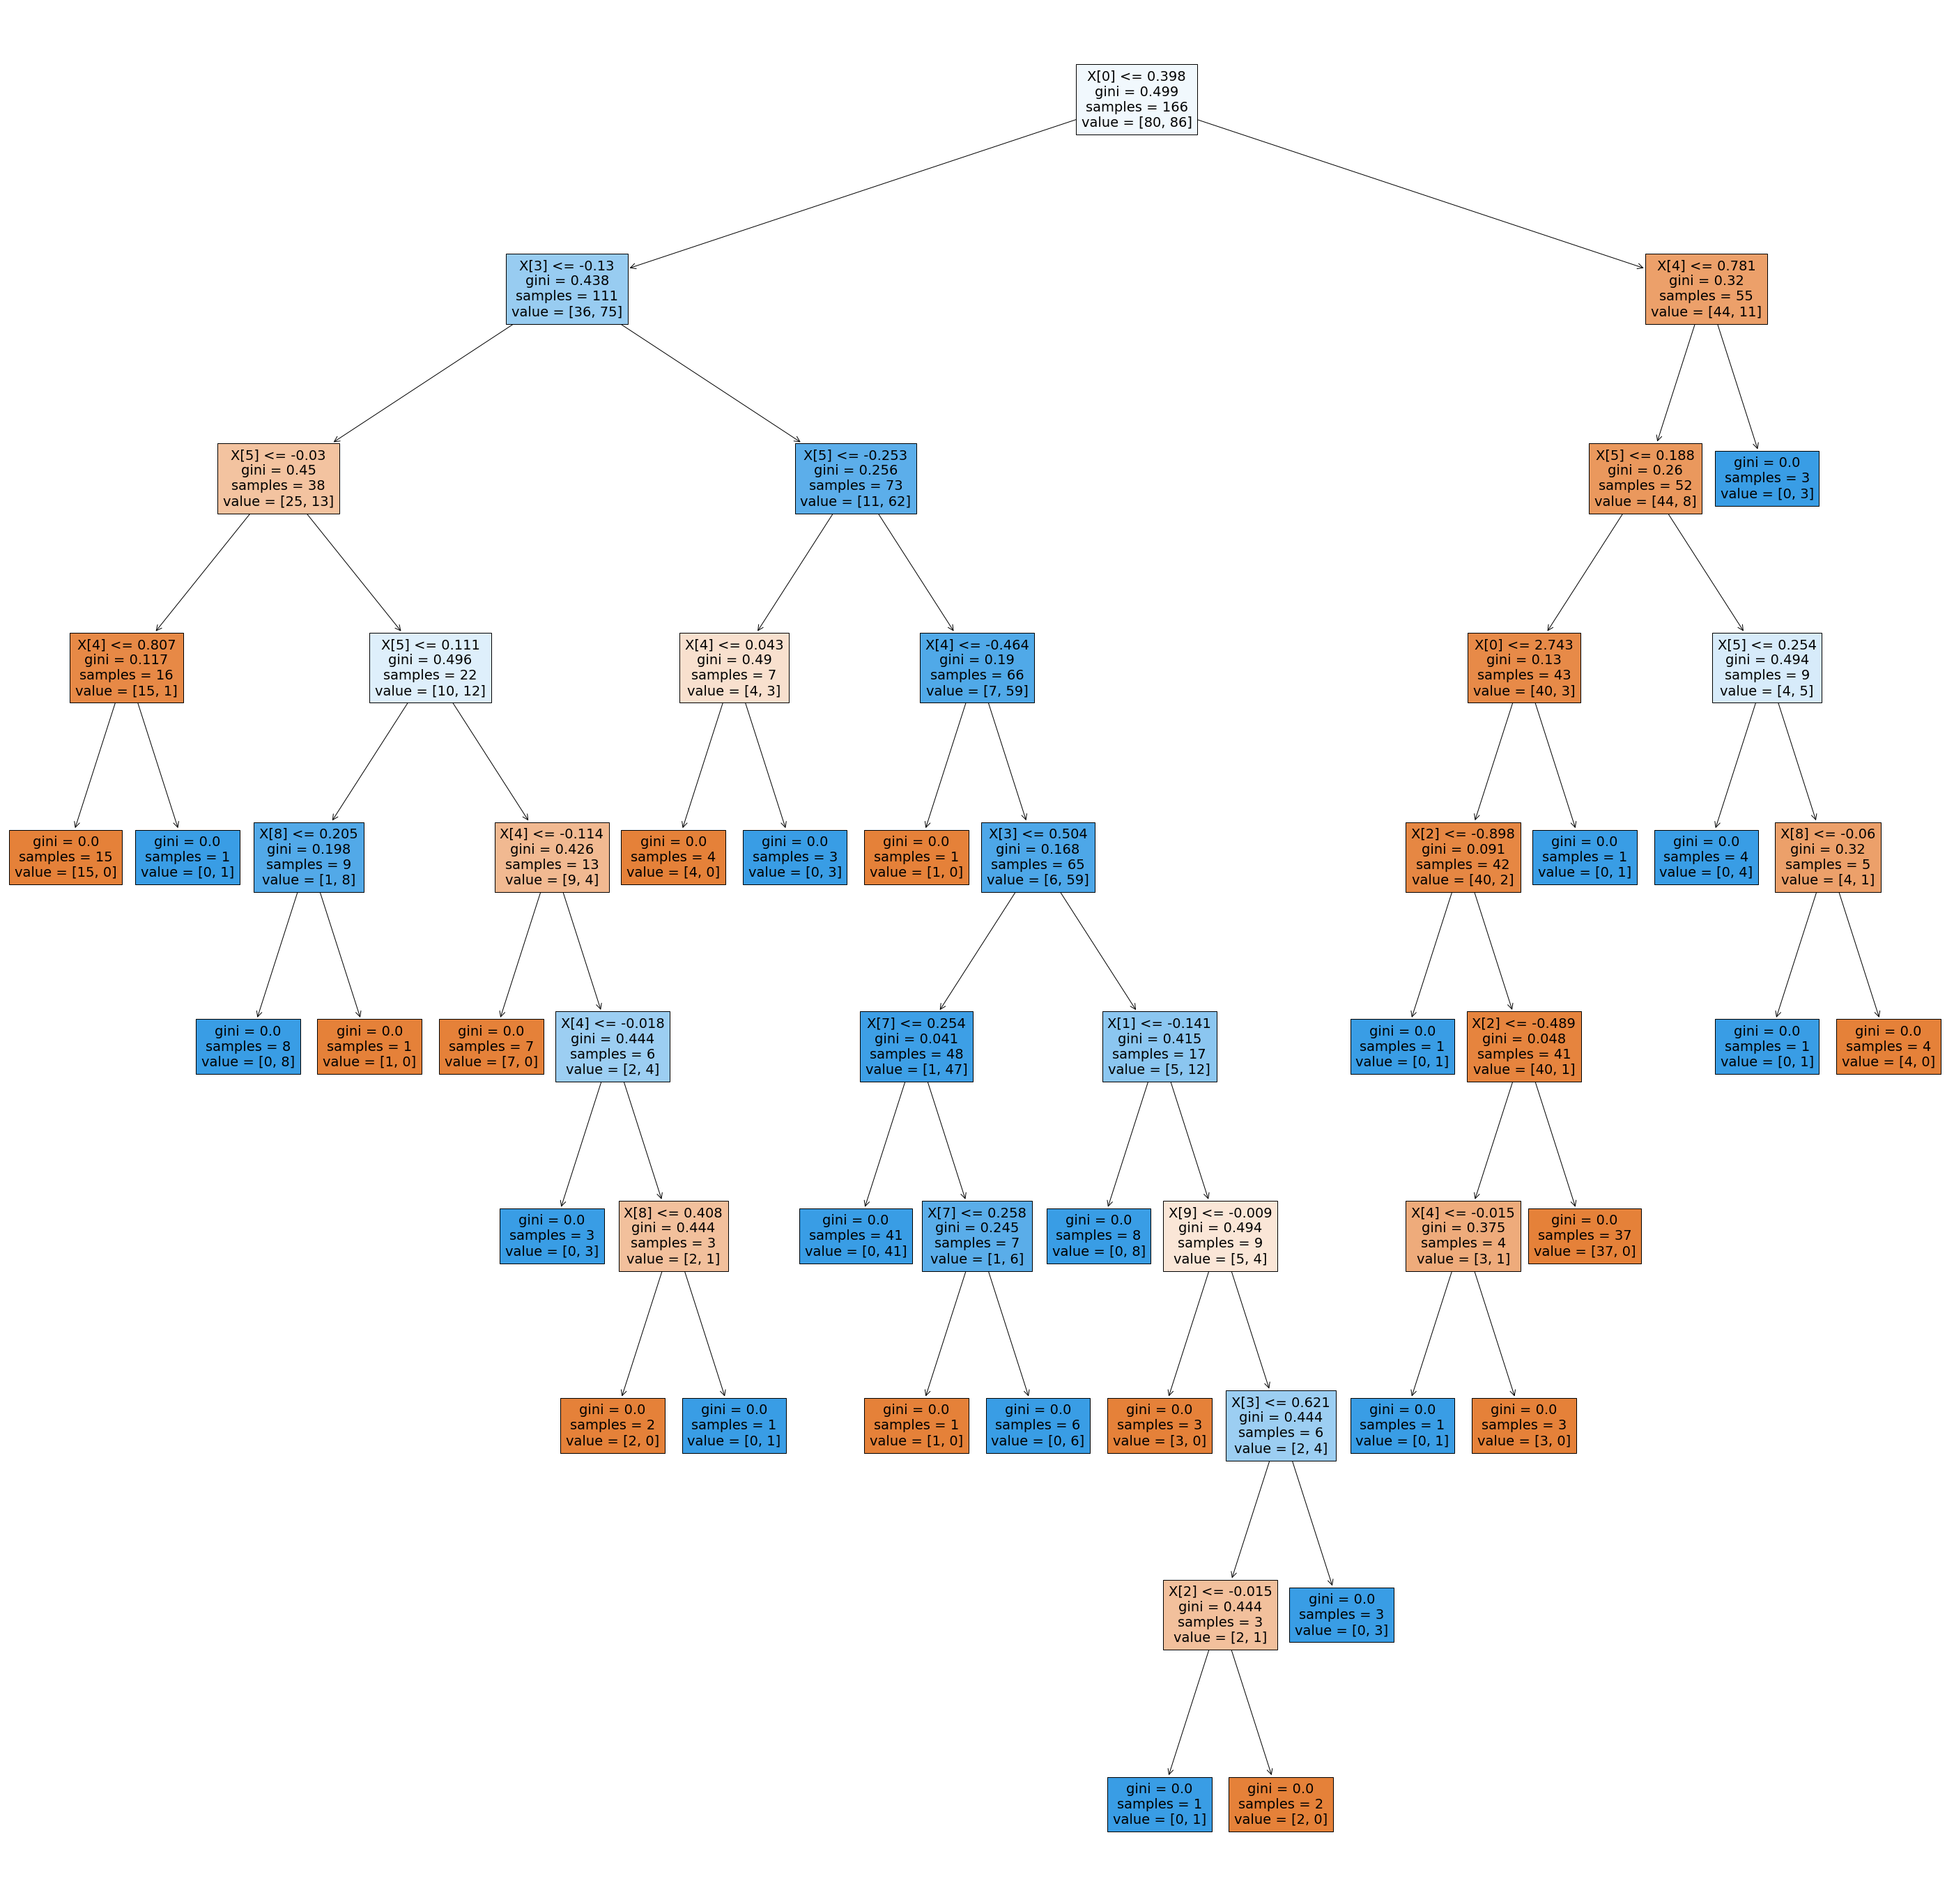

In [24]:
clfPCA = tree.DecisionTreeClassifier()
clfPCA = clfPCA.fit(X_trainPCA, y_trainPCA)

fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(clfPCA, filled=True)

- Decision Tree Classifier without PCA

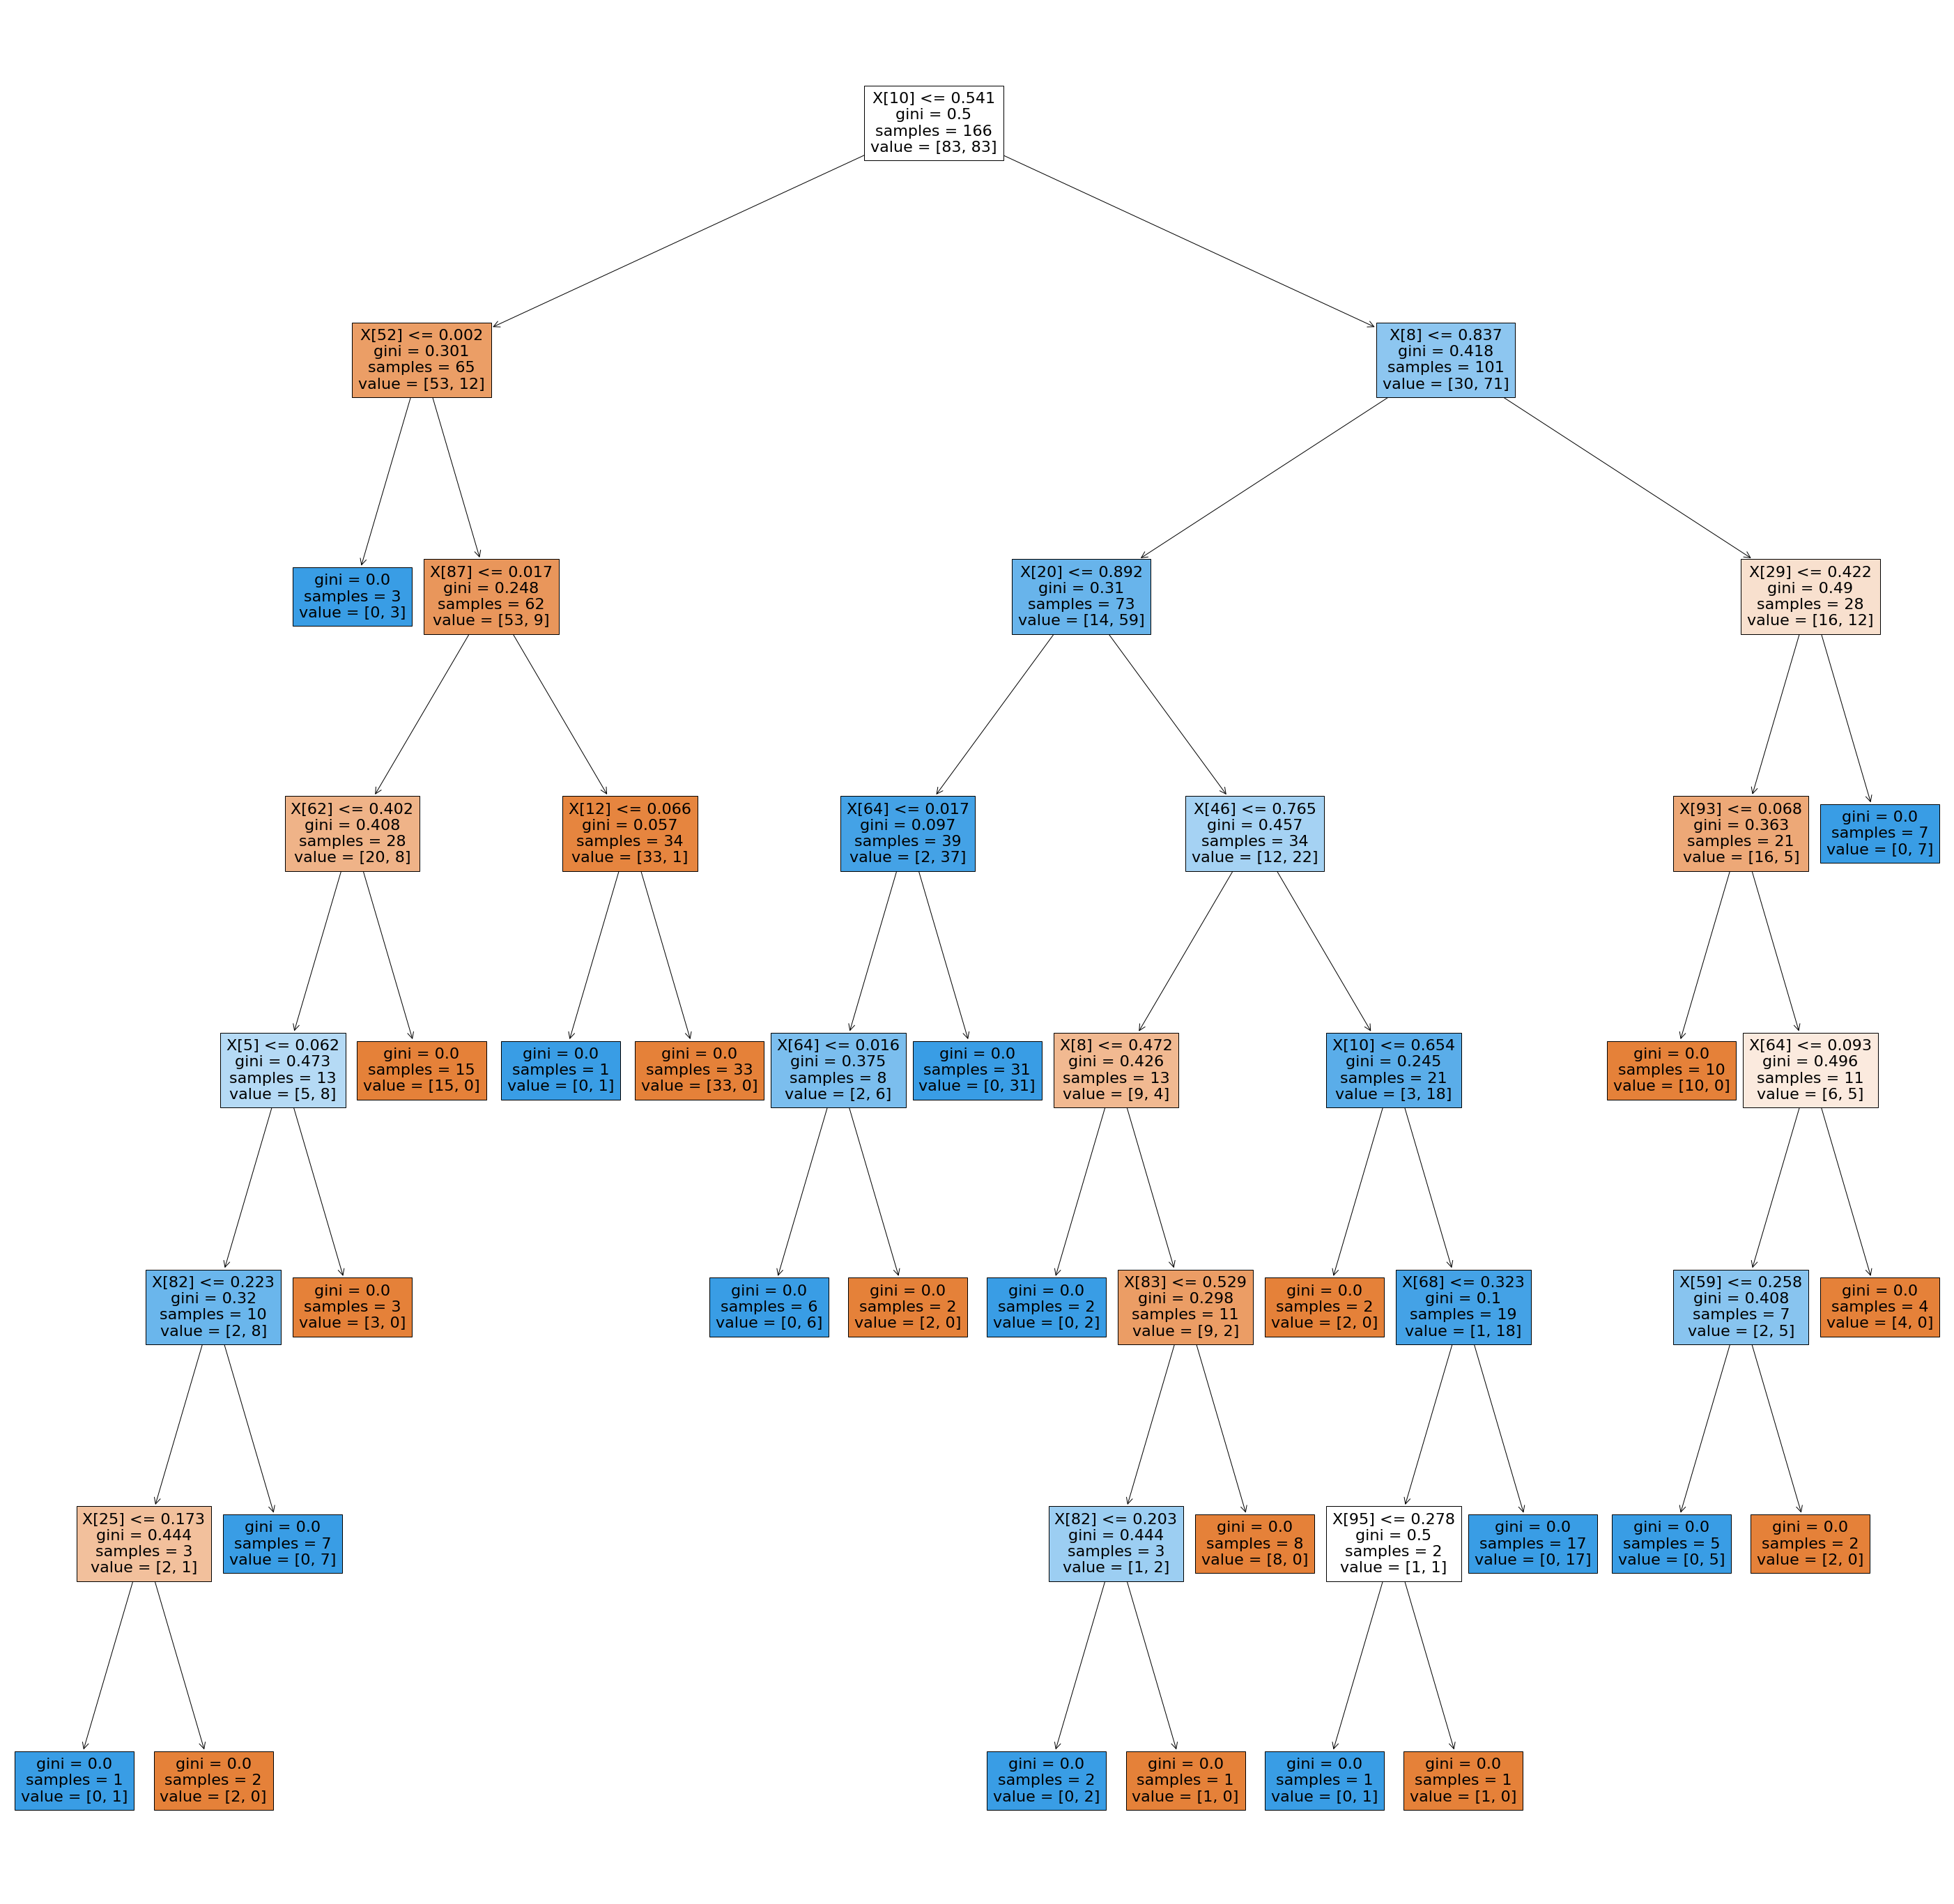

In [25]:
clfNOT = tree.DecisionTreeClassifier()
clfNOT = clfNOT.fit(X_train, y_train)

fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(clf, filled=True)

##### 5) Testing

In [27]:
y_PCA = clfPCA.predict(X_testPCA)
y_NOT = clfNOT.predict(X_test)

- cross-validation

In [28]:
cv_PCA = cross_val_score(clfPCA, Xpca, y)
print("---> with PCA :", cv_PCA)

---> with PCA : [0.68888889 0.73333333 0.59090909 0.70454545 0.70454545]


In [29]:
cv_NOT = cross_val_score(clfNOT, X, y)
print("---> without PCA :", cv_NOT)

---> without PCA : [0.66666667 0.64444444 0.61363636 0.65909091 0.65909091]


- confusion matrix

---> with PCA :


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

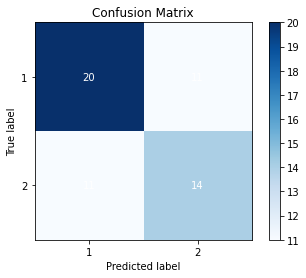

In [30]:
print("---> with PCA :")
plot_confusion_matrix(y_testPCA,y_PCA)

---> without PCA :


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

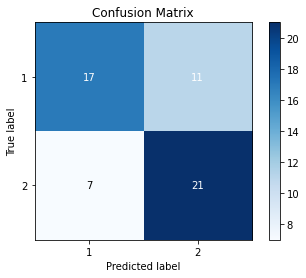

In [31]:
print("---> without PCA :")
plot_confusion_matrix(y_test,y_NOT)

- precision, recall, F-measure

In [32]:
f1_PCA = f1_score(y_testPCA,y_PCA)
print("---> with PCA :",f1_PCA)

---> with PCA : 0.6451612903225806


In [33]:
f1_NOT = f1_score(y_test,y_NOT)
print("---> without PCA :",f1_NOT)

---> without PCA : 0.6538461538461539


- roc curves

---> with PCA :


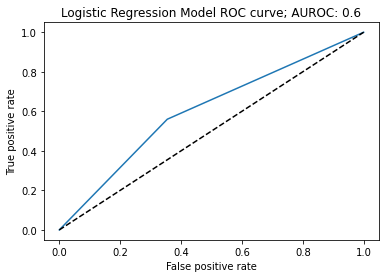

In [34]:
print("---> with PCA :")

fpr,tpr,thresholds = roc_curve(y_testPCA,y_PCA,pos_label=2)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

AUROC = np.round(roc_auc_score(y_testPCA, y_PCA), 2)

plt.title(f'Logistic Regression Model ROC curve; AUROC: {AUROC}');
plt.show()

---> without PCA :


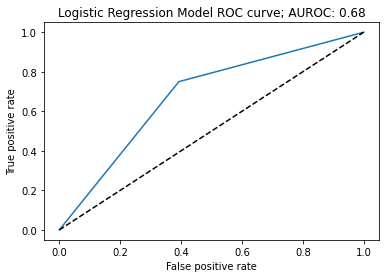

In [35]:
print("---> without PCA :")

fpr,tpr,thresholds = roc_curve(y_test,y_NOT,pos_label=2)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

AUROC = np.round(roc_auc_score(y_test, y_NOT), 2)

plt.title(f'Logistic Regression Model ROC curve; AUROC: {AUROC}');
plt.show()